# Test Trotterization on FakeJakarta with QREM and ZNE

- Status: Incomplete

# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pprint import pprint
# plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation import expectation_value

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_31378/3056705909.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.quantum_info import state_fidelity

# Import Libraries

In [6]:
import sys
import importlib
sys.path.append("./")
import circuit_utils, zne_utils, tomography_utils, sgs_algorithm
importlib.reload(circuit_utils)
importlib.reload(zne_utils)
importlib.reload(tomography_utils)
importlib.reload(sgs_algorithm)
from circuit_utils import *
from zne_utils import *
from tomography_utils import *
from sgs_algorithm import *

# Set Parameters

In [7]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Number of trotter steps
num_steps = 100
print("trotter step: ", num_steps)

scale_factors = [1.0, 2.0, 3.0, 4.0, 5.0]

trotter step:  100


# Prepare Circuits

logical circuits = little endian
name: lq = logical qubits 

In [8]:
# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(num_qubits, name="q")
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

subspace_encoder_init110(qc, targets=[0, 1, 2]) # encode
trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
subspace_decoder(qc, targets=[0,1,2]) # decode

In [9]:
# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
t1 = time.perf_counter()
qc = qc.bind_parameters({dt: target_time / num_steps})
t2 = time.perf_counter()
print("created qc,", t2 - t1, "s")

# Generate state tomography circuits to evaluate fidelity of simulation
t1 = time.perf_counter()
st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
t2 = time.perf_counter()
print("created st_qcs (length:", len(st_qcs), "),", t2 - t1, "s")

# remove barriers
t1 = time.perf_counter()
st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
t2 = time.perf_counter()
print("removed barriers from st_qcs,", t2 - t1, "s")

# optimize circuit
t1 = time.perf_counter()
t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
t2 = time.perf_counter()
print("created t3_st_qcs (length:", len(t3_st_qcs), "),", t2 - t1, "s")

created qc, 0.03908788099999949 s
created st_qcs (length: 27 ), 0.03199654299999999 s
removed barriers from st_qcs, 2.594670044 s
created t3_st_qcs (length: 27 ), 15.154727339000003 s


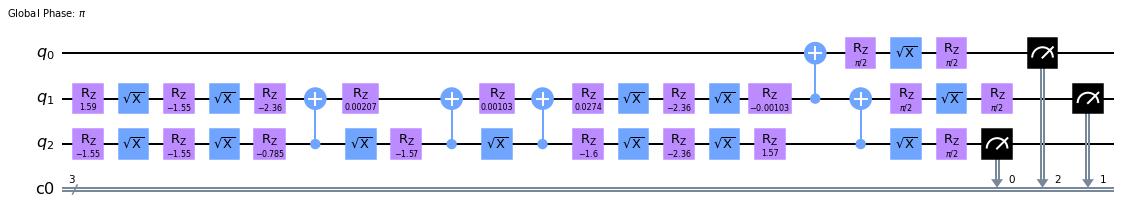

In [10]:
t3_st_qcs[0].draw("mpl")

In [11]:
# zne wrapping
t1 = time.perf_counter()
zne_qcs = zne_wrapper(t3_st_qcs, scale_factors=scale_factors)
t2 = time.perf_counter()
print("created zne_qcs (length:", len(zne_qcs), "),", t2 - t1, "s")

t1 = time.perf_counter()
zne_qcs = transpile(zne_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"])
t2 = time.perf_counter()
print("decomposed zne_qcs into basis gates (length:", len(zne_qcs), "),", t2 - t1, "s")

t1 = time.perf_counter()
t3_zne_qcs = transpile(zne_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
t2 = time.perf_counter()
print("optimized zne_qcs -> create t3_zne_qcs (length:", len(t3_zne_qcs), "),", t2 - t1, "s")

t1 = time.perf_counter()
t3_zne_qcs = transpile(t3_zne_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"], initial_layout=initial_layout)
t2 = time.perf_counter()
print("fit the t3_zne_qcs to the initial layoit (length:", len(t3_zne_qcs), "),", t2 - t1, "s")

created zne_qcs (length: 135 ), 29.204511293999996 s
decomposed zne_qcs into basis gates (length: 135 ), 3.082539447000002 s
optimized zne_qcs -> create t3_zne_qcs (length: 135 ), 22.156718466 s
fit the t3_zne_qcs to the initial layoit (length: 135 ), 0.5257115769999956 s


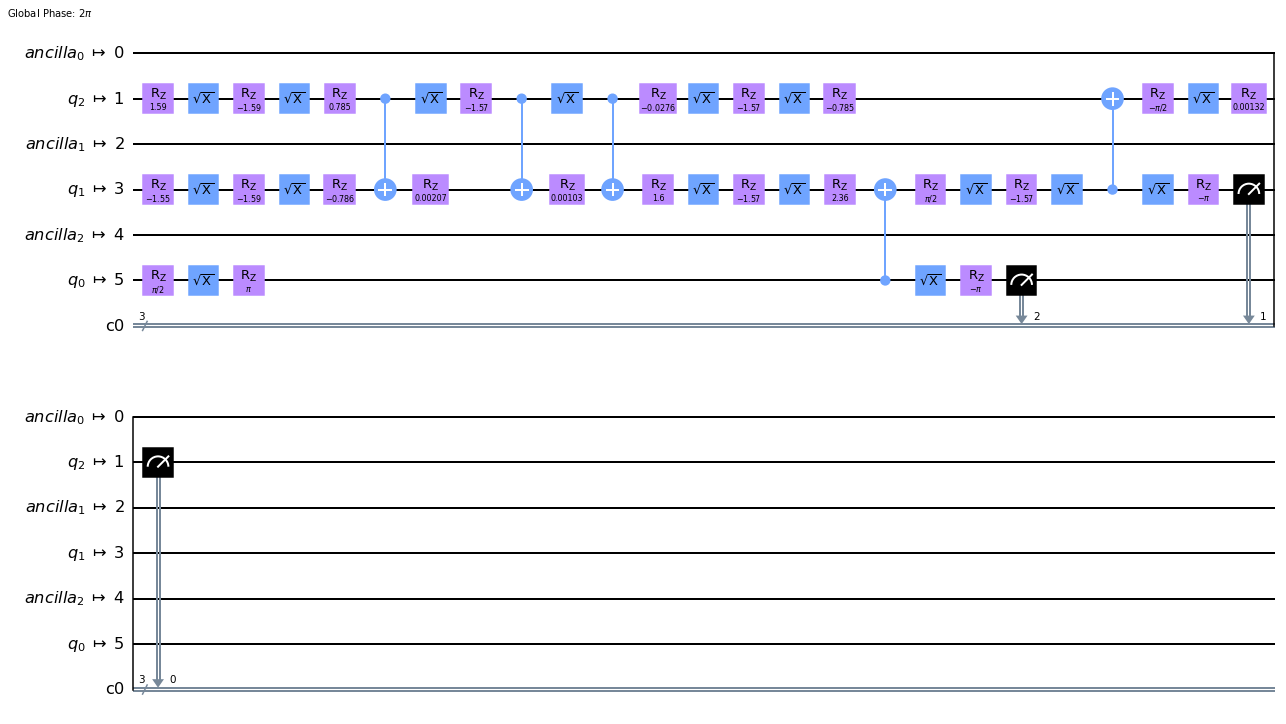

In [12]:
t3_zne_qcs[-3].draw("mpl")

# Set Backend

In [13]:
from qiskit.test.mock import FakeJakarta
backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
# print("provider:", provider)
# backend = provider.get_backend("ibmq_jakarta")

# Execute Circuits

In [14]:
shots = 1 << 13
reps = 1 # unused
# Number of trotter steps
print("trotter step: ", num_steps)
# execute: reps = 1
job = execute(t3_zne_qcs, backend, shots=shots) # 毎回チェック: ここちゃんと変えた？
print('Job ID', job.job_id())

trotter step:  100
Job ID 9f07b48c-5af6-42a7-a918-090d0bd73e56


# QREM

In [15]:
# QREM
qr = QuantumRegister(num_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout = initial_layout)
print('Job ID', cal_job.job_id())

Job ID dd9597f3-2524-4439-bc5c-883aad832d9d


In [16]:
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

In [17]:
mit_results = meas_fitter.filter.apply(job.result())

In [18]:
zne_expvals = zne_decoder(num_qubits, mit_results, scale_factors=scale_factors)

# State Tomography

In [19]:
target_state = (One^One^Zero).to_matrix() # DO NOT CHANGE!!!

In [20]:
rho = expvals_to_valid_rho(num_qubits, zne_expvals)

In [21]:
fidelity = state_fidelity(rho, target_state)

In [22]:
print(fidelity)

0.18462209528561216
